In [ ]:
using DrWatson
@quickactivate "APLG"
include(srcdir("pdes.jl"));
include(srcdir("plotting.jl"));
include(srcdir("travelling.jl"));
using KernelDensitySJ, Peaks, PyPlot


In [2]:
"""
Generate a figure showing the evolution of active-passive phase separation.

The figure contains:
- Space-time plots showing particle density and polarization
- Final state density profiles
- Color bars for density and polarization

Parameters
----------
param : Dict
    Simulation parameters including:
    - Nx : Number of spatial grid points
    - Lx : System size
    - Δx : Grid spacing
"""
function generate_figure(param;center_pattern = true)
    @unpack Nx = param

    # Load and process simulation data
    ts, f_saves = load_compress_pde(param)
    ft = permutedims(reshape(reduce(hcat,f_saves),(Nx,3,:)),(3,1,2))
    
    # Center the pattern around peak
    pk = find_xpeak_ft(ts, ft; time_length=0.1)
    if center_pattern
        centre = Nx ÷ 2 + 1 
    else 
        centre = 1;
    end
    ft = circshift(ft, (0,centre-pk, 0))

    # Generate visualization data
    t_pde_rgb_image = rho_to_rgb(ft)
    dt, df = t_dff(ts, ft; N=Nx)

    fts = [ft]
    times = [ts]
    images = [t_pde_rgb_image]
    dts = [dt]
    dfs = [df]

    # Set plot parameters
    t_max = maximum(ts)
    @unpack Lx = param
    rhomax = 1.0
    rhomin = 0.0
    mag_lim = 0.8
    
    # Layout parameters
    height_1 = 0.08
    width_1 = 0.48
    side_gap_1 = 0.35
    bottom_gap_1 = 0.65
    gap = 0.012

    cbar_y_top = bottom_gap_1 + 3*height_1 + 2*gap
    cbar_width = 0.1
    cbar_y_bot = bottom_gap_1 + gap + height_1
    cbar_x = 0.885

    height_2 = 0.175
    width_2 = height_2
    side_gap_2 = 0.1
    bottom_gap_2 = bottom_gap_1
    gap_2 = 0.06

    width_3 = 0.25
    start_3 = 0.05
    font = 15
    sf = 1.0

    # Initialize figure
    rc("text", usetex=true)
    fig = plt.figure(figsize=(10,Int64(10*sf)))
    ax = fig.add_axes([0,0,1,1],visible=true)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.spines["bottom"].set_visible(false)
    ax.spines["left"].set_visible(false)

    # Add space-time plots
    for (i,(rgb_image,ts)) in enumerate(zip(images, times))
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1), bottom_gap_1, width_1, height_1])
        t_end = ts[end]
        t_start = ts[1]
        t_max = t_end - t_start
        
        ax.imshow(rgb_image; extent=[t_start,t_end,0,Lx], interpolation="bilinear")
        ax.get_yaxis().set_ticks(0:20.0:Lx)
        ax.get_xaxis().set_ticks([])
        ax.axis([0,t_max, 0, Lx])
        ax.set_aspect((t_max/Lx)*(height_1/width_1)*sf)
        ax.set_ylabel(L"x",fontsize=font, rotation=90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(t_max); digits=0):round(t_max;digits=0))
        ax.set_xlabel(L"t", fontsize=font)
        ax.tick_params(labelbottom=true, direction="in")
    end

    # Add density and polarization plots
    for (i,(ts,ft)) in enumerate(zip(times, fts))
        global im1, im2
        
        # Total density plot
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1), bottom_gap_1+2*height_1+2*gap, width_1, height_1])
        t_end = ts[end]
        t_start = ts[1]
        t_max = t_end - t_start
        _, Nx, _ = size(ft)

        colmap = PyPlot.plt.cm.viridis
        norm1 = matplotlib.colors.Normalize(vmin=rhomin, vmax=rhomax) 
        im1 = ax.matshow((ft[:,Nx:-1:1,1]+ft[:,Nx:-1:1,2]+ft[:,Nx:-1:1,3])'; 
                        norm=norm1, cmap=colmap, extent=[t_start,t_end,0,Lx])

        ax.xaxis.set_ticks([])
        ax.xaxis.tick_bottom()
        ax.get_yaxis().set_ticks(0:20.0:Lx)
        ax.axis([0,t_max, 0, Lx])
        ax.set_aspect((t_max/Lx)*(height_1/width_1)*sf)
        ax.set_ylabel(L"x",fontsize=font, rotation=90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(t_max); digits=0):round(t_max;digits=0))
        ax.tick_params(labelbottom=false, direction="in")

        # Polarization plot
        ax = fig.add_axes([side_gap_1+(i-1)*(side_gap_1+width_1),bottom_gap_1+height_1+gap, width_1, height_1])
        colmap = PyPlot.plt.cm.PRGn
        norm1 = matplotlib.colors.Normalize(vmin=-mag_lim, vmax=mag_lim) 
        im2 = ax.matshow((ft[:,Nx:-1:1,2]-ft[:,Nx:-1:1,1])'; 
                        norm=norm1, cmap=colmap, extent=[t_start,t_end,0,Lx])
        
        ax.get_yaxis().set_ticks(0:20.0:Lx)
        ax.xaxis.tick_bottom()
        ax.axis([0,t_max, 0, Lx])
        ax.set_aspect((t_max/Lx)*(height_1/width_1)*sf)
        ax.set_ylabel(L"x",fontsize=font, rotation=90)
        ax.get_xaxis().set_ticks(0:round(0.25*round(t_max); digits=0):round(t_max;digits=0))
        ax.tick_params(labelbottom=false, direction="in")
    end

    # Add final state plot
    frame = length(ts)-1
    ax = fig.add_axes([start_3, bottom_gap_2, width_3, 3*height_1+2*gap])
    ax.plot(Δx:Δx:Lx, ft[frame,:,2]+ft[frame,:,1]+ft[frame,:,3];
            color="black", linestyle="-", label=L"\rho")
    ax.plot(Δx:Δx:Lx, ft[frame,:,1]+ft[frame,:,2]; 
            color="red", linestyle="--", label=L"\rho_a")
    ax.plot(Δx:Δx:Lx, ft[frame,:,3]; 
            color="blue", linestyle=":",label=L"\rho_0")
    ax.plot(Δx:Δx:Lx, ft[frame,:,2]-ft[frame,:,1]; 
            color="green", linestyle="-.", label=L"m")

    latex_string = latexstring("\$ t = $(d2(ts[end]))\$")
    ax.set_title(latex_string, fontsize=font)
    ax.get_xaxis().set_ticks(0:10.0:Lx)
    ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
    ax.set_aspect((3*height_1+2*gap)*(Lx/(1.25))/(width_3))
    ax.axis([0,Lx,-0.25,1.0])
    ax.tick_params(direction="in")
    ax.legend(loc="upper right", fontsize=12, edgecolor="white")
    ax.set_xlabel(L"x", fontsize=15)

    # Add color bars
    # Active-passive colorbar
    cbar_ax = fig.add_axes([cbar_x, bottom_gap_2, height_1, height_1])
    Δ = 0.001
    cbar_f = [x*(x+y≤1)*(i!=3)/2 + y*(x+y≤1)*(i==3) for x in Δ:Δ:1, y in Δ:Δ:1, i in 1:3]  
    rgb_image = rho_to_rgb(cbar_f)

    ax = cbar_ax
    ax.imshow(rgb_image; extent=[0,1,0,1])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.get_xaxis().set_ticks(0:0.5:1)
    ax.get_yaxis().set_ticks(0:0.5:1)
    ax.set_xlabel(L"\rho_a", fontsize=font)
    ax.set_ylabel(L"\rho_0",fontsize=font, rotation=90)
    ax.tick_params(direction="in")

    # Density colorbar
    rho_cbar_ax = fig.add_axes([cbar_x, cbar_y_bot+gap+height_1, 0.025, height_1])
    rho_cbar = fig.colorbar(im1, cax=rho_cbar_ax)
    rho_cbar_ax.set_ylabel(L"\rho",fontsize=font,rotation=90)
    rho_cbar.set_ticks(rhomin:0.5:rhomax)
    rho_cbar_ax.yaxis.set_ticks_position("right")
    rho_cbar_ax.tick_params(direction="in")

    # Polarization colorbar
    mag_cbar_ax = fig.add_axes([cbar_x, cbar_y_bot, 0.025, height_1])
    mag_cbar = fig.colorbar(im2, cax=mag_cbar_ax)
    mag_cbar.set_ticks((-mag_lim):0.8:mag_lim)
    mag_cbar_ax.tick_params(direction="in")
    mag_cbar_ax.yaxis.set_ticks_position("right")
    mag_cbar_ax.set_ylabel(L"m",fontsize=font,rotation=90)

    # Add labels
    ax.annotate(L"(a)", (start_3 - 0.04, bottom_gap_2+3*height_1+2*gap), 
                xycoords="figure fraction", rotation=0, fontsize=font)
    ax.annotate(L"(b)", (side_gap_1 - 0.03, bottom_gap_2+3*height_1+2*gap), 
                xycoords="figure fraction", rotation=0, fontsize=font)

    return fig;
end

generate_figure

# Figure 4

/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/fig_4/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 7.5, 1.0, 0.05, 25.0, 0.36, 0.3]/T=1000.0_Δt=1.0.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/fig_4/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 7.5, 1.0, 0.05, 25.0, 0.36, 0.3]/T=1000.0_Δt=1.0.jld2
fast load pde


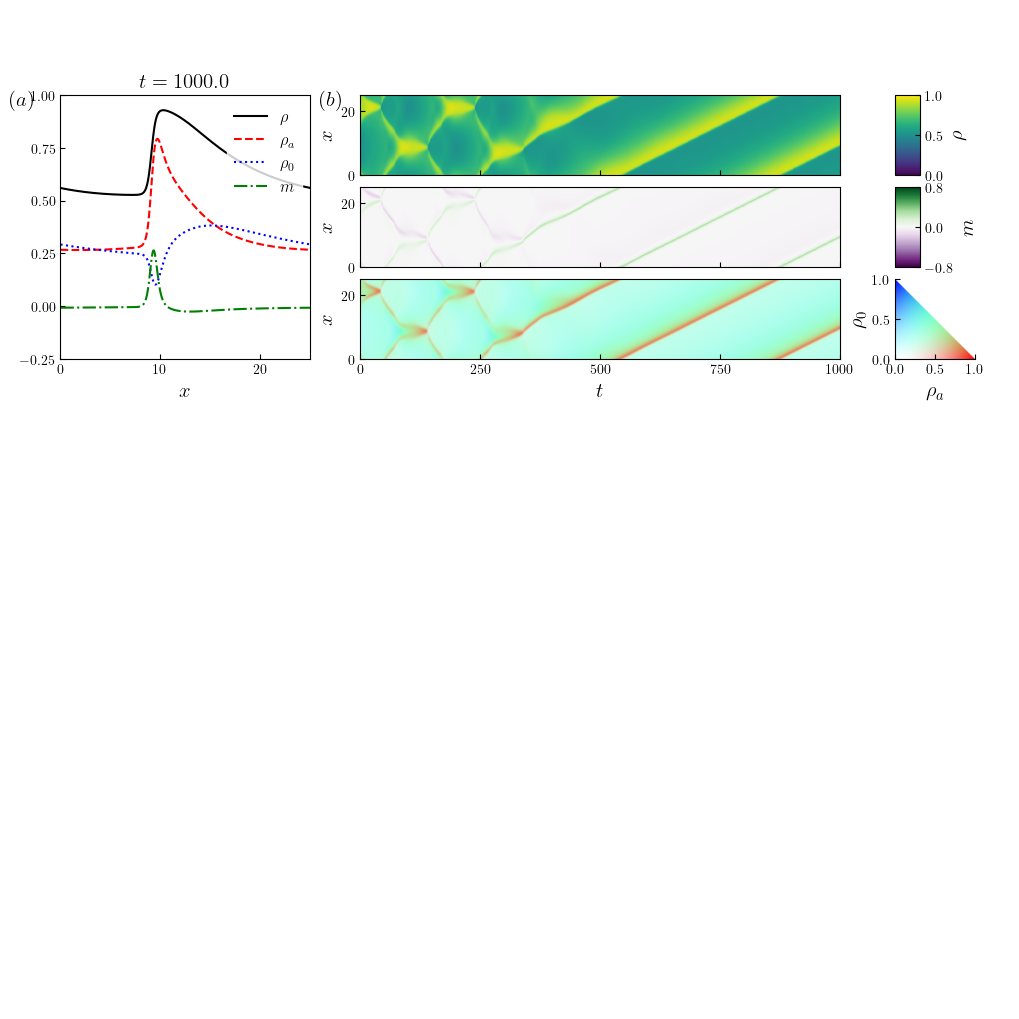

In [3]:
DT, v0, DR, N, Δx, Lx, Ly, δt, δ, ϕa, ϕp = (1.0, 7.5, 1.0, 100, 0.05, 25.0, 0.5, 1e-5, 0.1, 0.36, 0.3);
T, save_interval, param_name, pert = (1000.0, 1.0, "fig_4", "lin")
param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true, pert= pert);

fig4 = generate_figure(param);

# Figure S5

/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/fig_S5/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 7.5, 1.0, 0.05, 100.0, 0.5, 0.3]/T=4000.0_Δt=10.0.jld2
/Users/bruna/Documents/People/Mason_James/Nonreciprocal_APLG/data/pm_pdes_pro/fig_S5/[DT,v0,DR,Δx,Lx,ϕa,ϕp]=[1.0, 7.5, 1.0, 0.05, 100.0, 0.5, 0.3]/T=4000.0_Δt=10.0.jld2
fast load pde


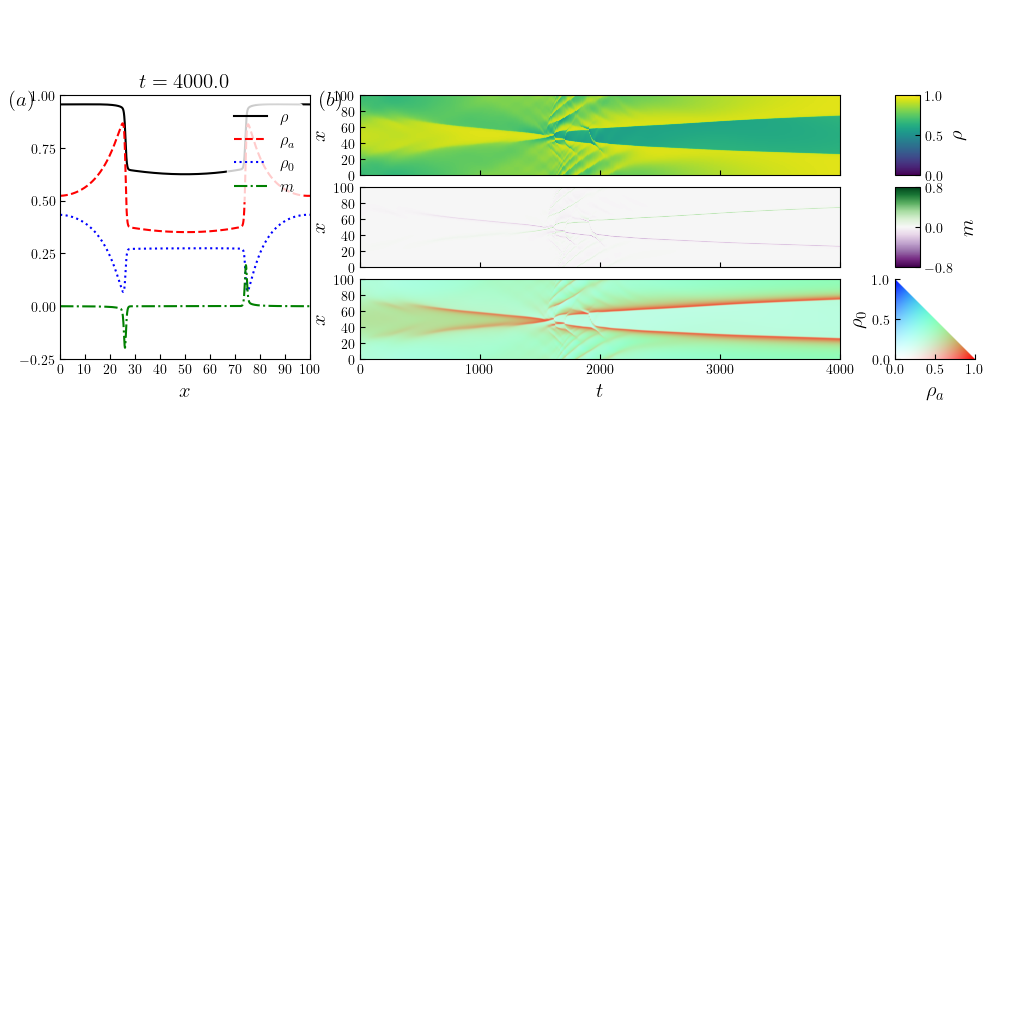

In [4]:
DT, v0, DR, N, Δx, Lx, Ly, δt, δ, ϕa, ϕp = (1.0, 7.5, 1.0, 100, 0.05, 100.0, 0.5, 1e-5, 0.1, 0.5, 0.3);
T, save_interval, param_name, pert = (4000.0, 10.0, "fig_S5", "lin")
param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true, pert= pert)

figS5 = generate_figure(param;center_pattern = false);